#Mount Google Drive

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import SpatialDropout2D, GaussianNoise
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc, f1_score, precision_recall_fscore_support
import seaborn as sns
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import pickle
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
from sklearn.model_selection import KFold
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import precision_recall_curve

In [3]:
print(tf.__version__)

2.17.0


#Define the directory to save the models

In [4]:
# Define the directories to save the models
base_dir = '/content/drive/My Drive/MENG/ANN'
os.makedirs(base_dir, exist_ok=True)

checkpoint_dir = os.path.join(base_dir, 'checkpoints')
os.makedirs(checkpoint_dir, exist_ok=True)

history_dir = os.path.join(base_dir, 'history')
os.makedirs(history_dir, exist_ok=True)

#Download Brain Mask Image Dataset from Kagle

In [5]:
# Install Kaggle API
!pip install kaggle

# Upload Kaggle API token
from google.colab import files
files.upload()  # This will prompt you to upload the kaggle.json file

# Create .kaggle directory and move kaggle.json there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d nikhilroxtomar/brain-tumor-segmentation

# Unzip the dataset
!unzip brain-tumor-segmentation.zip -d brain_tumor_segmentation

Streaming output truncated to the last 5000 lines.
  inflating: brain_tumor_segmentation/images/2013.png  
  inflating: brain_tumor_segmentation/images/2014.png  
  inflating: brain_tumor_segmentation/images/2015.png  
  inflating: brain_tumor_segmentation/images/2016.png  
  inflating: brain_tumor_segmentation/images/2017.png  
  inflating: brain_tumor_segmentation/images/2018.png  
  inflating: brain_tumor_segmentation/images/2019.png  
  inflating: brain_tumor_segmentation/images/202.png  
  inflating: brain_tumor_segmentation/images/2020.png  
  inflating: brain_tumor_segmentation/images/2021.png  
  inflating: brain_tumor_segmentation/images/2022.png  
  inflating: brain_tumor_segmentation/images/2023.png  
  inflating: brain_tumor_segmentation/images/2024.png  
  inflating: brain_tumor_segmentation/images/2025.png  
  inflating: brain_tumor_segmentation/images/2026.png  
  inflating: brain_tumor_segmentation/images/2027.png  
  inflating: brain_tumor_segmentation/images/2028.png 

#Split the Dataset

In [6]:
# Define paths
data_dir = 'brain_tumor_segmentation'  # directory containing all images and masks
image_dir = os.path.join(data_dir, 'images')
mask_dir = os.path.join(data_dir, 'masks')
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# Create directories for train, val, and test sets
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get list of all image files
image_files = os.listdir(image_dir)

# Split into train, val, and test sets
train_files, temp_files = train_test_split(image_files, test_size=0.3, random_state=42)
val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

# Function to copy files to destination directory
def copy_files(file_list, dest_dir):
    os.makedirs(os.path.join(dest_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(dest_dir, 'masks'), exist_ok=True)
    for file_name in file_list:
        shutil.copy(os.path.join(image_dir, file_name), os.path.join(dest_dir, 'images', file_name))
        shutil.copy(os.path.join(mask_dir, file_name), os.path.join(dest_dir, 'masks', file_name))

# Copy files to train, val, and test directories
copy_files(train_files, train_dir)
copy_files(val_files, val_dir)
copy_files(test_files, test_dir)

print('Dataset split into train, val, and test sets successfully.')

# Function to count files in a directory
def count_files(dir_path):
    images_path = os.path.join(dir_path, 'images')
    masks_path = os.path.join(dir_path, 'masks')
    num_images = len(os.listdir(images_path))
    num_masks = len(os.listdir(masks_path))
    return num_images, num_masks

# Print the number of files in each directory
train_images, train_masks = count_files(train_dir)
val_images, val_masks = count_files(val_dir)
test_images, test_masks = count_files(test_dir)

print(f'Training set: {train_images} images, {train_masks} masks')
print(f'Validation set: {val_images} images, {val_masks} masks')
print(f'Test set: {test_images} images, {test_masks} masks')

Dataset split into train, val, and test sets successfully.
Training set: 2144 images, 2144 masks
Validation set: 460 images, 460 masks
Test set: 460 images, 460 masks


#Custom Data Generator

In [7]:
# Define directories for brain tumor segmentation dataset
train_image_dir = 'brain_tumor_segmentation/train/images'
train_mask_dir = 'brain_tumor_segmentation/train/masks'
val_image_dir = 'brain_tumor_segmentation/val/images'
val_mask_dir = 'brain_tumor_segmentation/val/masks'
test_image_dir = 'brain_tumor_segmentation/test/images'
test_mask_dir = 'brain_tumor_segmentation/test/masks'

# Define image size and batch size
IMAGE_SIZE = (512, 512)
BATCH_SIZE = 8

# Function to create a custom data generator with sampling and augmentation
def custom_data_generator(image_dir, mask_dir, batch_size, image_size, augment=False):
    image_filenames = sorted(os.listdir(image_dir))
    mask_filenames = sorted(os.listdir(mask_dir))

    # Define ImageDataGenerator for augmentation
    if augment:
        image_datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            zoom_range=0.3,
            brightness_range=[0.7, 1.3],
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='nearest'
        )
        mask_datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            zoom_range=0.3,
            brightness_range=[0.7, 1.3],
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='nearest'
        )
    # else:
    #     image_datagen = ImageDataGenerator(rescale=1./255)
    #     mask_datagen = ImageDataGenerator(rescale=1./255)

    while True:
        sampled_indices = random.sample(range(len(image_filenames)), batch_size)
        img_batch = [image_filenames[i] for i in sampled_indices]
        mask_batch = [mask_filenames[i] for i in sampled_indices]

        images = []
        masks = []

        for img, mask in zip(img_batch, mask_batch):
            img_path = os.path.join(image_dir, img)
            mask_path = os.path.join(mask_dir, mask)

            img = load_img(img_path, target_size=image_size, color_mode='grayscale')
            mask = load_img(mask_path, target_size=image_size, color_mode='grayscale')

            img = img_to_array(img)
            mask = img_to_array(mask)

            if augment:
                seed = random.randint(0, 10000)
                img = image_datagen.random_transform(img, seed=seed)
                mask = mask_datagen.random_transform(mask, seed=seed)

            # Normalization
            img = img / 255.0
            mask = mask / 255.0

            images.append(img)
            masks.append(mask)

        yield np.array(images), np.array(masks)

# Create the data generators with sampling and augmentation for training
train_generator = custom_data_generator(train_image_dir, train_mask_dir, BATCH_SIZE, IMAGE_SIZE, augment=True)
val_generator = custom_data_generator(val_image_dir, val_mask_dir, BATCH_SIZE, IMAGE_SIZE)
test_generator = custom_data_generator(test_image_dir, test_mask_dir, BATCH_SIZE, IMAGE_SIZE)

print('Data generators created successfully.')

# Inspect a batch from the train generator
images, masks = next(train_generator)

# Print the shapes of the images and masks
print("Images shape:", images.shape)
print("Masks shape:", masks.shape)

# Print some statistics to check the content
print("Images dtype:", images.dtype)
print("Masks dtype:", masks.dtype)
print("Images min and max values:", images.min(), images.max())
print("Masks min and max values:", masks.min(), masks.max())

Data generators created successfully.
Images shape: (8, 512, 512, 1)
Masks shape: (8, 512, 512, 1)
Images dtype: float32
Masks dtype: float32
Images min and max values: 0.0 1.0
Masks min and max values: 0.0 1.0


#Calculate Class Weights

In [8]:
# Define paths to your mask directory
train_mask_dir = 'brain_tumor_segmentation/train/masks'

def calculate_class_weights(train_mask_dir):
    total_foreground_pixels = 0
    total_background_pixels = 0

    mask_filenames = os.listdir(train_mask_dir)
    for mask_filename in mask_filenames:
        mask_path = os.path.join(train_mask_dir, mask_filename)
        mask = load_img(mask_path, color_mode='grayscale')
        mask_array = img_to_array(mask).astype(np.uint8)

        total_foreground_pixels += np.sum(mask_array > 1)
        total_background_pixels += np.sum(mask_array == 0)

    if total_foreground_pixels == 0:
        total_foreground_pixels = 1

    class_weight = total_background_pixels / total_foreground_pixels
    return class_weight

class_weight = calculate_class_weights(train_mask_dir)

# Apply a scaling factor to avoid extremely high weights
scaling_factor = 0.0285
adjusted_class_weight = class_weight * scaling_factor

print(f'Calculated class weight: {class_weight}')
print(f'Adjusted class weight: {adjusted_class_weight}')

Calculated class weight: 58.800343346393475
Adjusted class weight: 1.675809785372214


#Define Weighted Binary Cross-Entropy Loss

In [9]:
@tf.keras.utils.register_keras_serializable()
def weighted_binary_crossentropy(y_true, y_pred, weight, label_smoothing=0.1):
    epsilon = tf.keras.backend.epsilon()
    y_true = tf.keras.backend.flatten(y_true)
    y_pred = tf.keras.backend.flatten(y_pred)
    y_pred = tf.keras.backend.clip(y_pred, epsilon, 1. - epsilon)

    # Apply label smoothing
    y_true = y_true * (1 - label_smoothing) + 0.5 * label_smoothing

    logit_y_pred = tf.keras.backend.log(y_pred / (1. - y_pred))
    loss = tf.keras.backend.mean(tf.nn.weighted_cross_entropy_with_logits(y_true, logit_y_pred, weight))
    return loss

@tf.keras.utils.register_keras_serializable()
def dice_coef_loss(y_true, y_pred):
    dice_numerator = 2 * tf.reduce_sum(y_true * y_pred)
    dice_denominator = tf.reduce_sum(y_true + y_pred)
    dice_loss = 1 - (dice_numerator + 1) / (dice_denominator + 1)
    return dice_loss

@tf.keras.utils.register_keras_serializable()
def focal_loss(y_true, y_pred, gamma=2., alpha=0.25):
    y_true = tf.keras.backend.flatten(y_true)
    y_pred = tf.keras.backend.flatten(y_pred)
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.keras.backend.clip(y_pred, epsilon, 1. - epsilon)
    p_t = (y_true * y_pred) + ((1 - y_true) * (1 - y_pred))
    alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
    modulating_factor = tf.keras.backend.pow((1.0 - p_t), gamma)
    loss = alpha_factor * modulating_factor * tf.keras.backend.binary_crossentropy(y_true, y_pred)
    return tf.keras.backend.mean(loss)

@tf.keras.utils.register_keras_serializable()
def combined_loss(y_true, y_pred):
    wbc_loss = weighted_binary_crossentropy(y_true, y_pred, adjusted_class_weight)
    dice_loss = dice_coef_loss(y_true, y_pred)
    f_loss = focal_loss(y_true, y_pred)
    return wbc_loss + dice_loss + f_loss

#Define Focal Loss

#UNet Model with Attention

In [10]:
@tf.keras.utils.register_keras_serializable()
# Define IoU Metric
def iou_metric(y_true, y_pred, smooth=1):
    intersection = tf.keras.backend.sum(tf.keras.backend.abs(y_true * y_pred), axis=[1, 2, 3])
    union = tf.keras.backend.sum(y_true, axis=[1, 2, 3]) + tf.keras.backend.sum(y_pred, axis=[1, 2, 3]) - intersection
    iou = tf.keras.backend.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

@tf.keras.utils.register_keras_serializable()
# Define Dice Coefficient
def dice_coef(y_true, y_pred, smooth=1):
    intersection = tf.keras.backend.sum(tf.keras.backend.abs(y_true * y_pred), axis=[1, 2, 3])
    dice = tf.keras.backend.mean((2. * intersection + smooth) / (tf.keras.backend.sum(y_true, axis=[1, 2, 3]) + tf.keras.backend.sum(y_pred, axis=[1, 2, 3]) + smooth), axis=0)
    return dice

@tf.keras.utils.register_keras_serializable()
# Define Gaussian Noise Layer
class GaussianNoise(layers.Layer):
    def __init__(self, stddev, **kwargs):
        super(GaussianNoise, self).__init__(**kwargs)
        self.stddev = stddev

    def call(self, inputs, training=None):
        if training:
            noise = tf.random.normal(shape=tf.shape(inputs), mean=0.0, stddev=self.stddev, dtype=inputs.dtype)
            return inputs + noise
        return inputs

@tf.keras.utils.register_keras_serializable()
# Define Squeeze-and-Excitation Block
def SEBlock(input_tensor, reduction=16):
    filters = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Dense(filters // reduction, activation='relu')(se)
    se = layers.Dense(filters, activation='sigmoid')(se)
    se = layers.Reshape((1, 1, filters))(se)
    return layers.multiply([input_tensor, se])

@tf.keras.utils.register_keras_serializable()
# Define Dense Block
def DenseBlock(x, filters, growth_rate, layers_per_block, dropout_rate=0.6):
    for i in range(layers_per_block):
        cb = layers.BatchNormalization()(x)
        cb = layers.ReLU()(cb)
        cb = layers.Conv2D(growth_rate, 3, padding='same', kernel_initializer='he_normal')(cb)
        cb = layers.Dropout(dropout_rate)(cb)
        x = layers.concatenate([x, cb])
        filters += growth_rate
    return x, filters

@tf.keras.utils.register_keras_serializable()
# Define Convolution Block with Atrous Convolution
def ConvBlock(x, filters, kernel_size=3, strides=1, dropout_rate=0.6, dilation_rate=1):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001), dilation_rate=dilation_rate)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001), dilation_rate=dilation_rate)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    return x

@tf.keras.utils.register_keras_serializable()
# Define Resize Layer
class ResizeLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(ResizeLayer, self).__init__(**kwargs)

    def call(self, inputs):
        x, target_shape = inputs
        return tf.image.resize(x, tf.cast(target_shape, tf.int32), method=tf.image.ResizeMethod.BILINEAR)

@tf.keras.utils.register_keras_serializable()
class AttentionBlock(layers.Layer):
    def __init__(self, filters, **kwargs):
        super(AttentionBlock, self).__init__(**kwargs)
        self.filters = filters

        # Define all Conv2D layers in __init__ to ensure variables are created once
        self.theta_x_layer = layers.Conv2D(self.filters, (2, 2), strides=(2, 2), padding='same')
        self.phi_g_layer = layers.Conv2D(self.filters, (1, 1), padding='same')
        self.psi_layer = layers.Conv2D(1, (1, 1), padding='same')
        self.relu = layers.ReLU()
        self.sigmoid = layers.Activation('sigmoid')

    def call(self, g, x):
        # Downsample 'x' with a stride to match the dimension of 'g'
        theta_x = self.theta_x_layer(x)

        # Resize 'theta_x' to match 'g' dimensions
        resized_theta_x = tf.image.resize(theta_x, tf.shape(g)[1:3], method='bilinear')

        phi_g = self.phi_g_layer(g)

        # Combine both feature maps
        f = layers.add([resized_theta_x, phi_g])
        f = self.relu(f)
        psi_f = self.psi_layer(f)
        rate = self.sigmoid(psi_f)

        # Resize rate to match x
        resized_rate = tf.image.resize(rate, tf.shape(x)[1:3], method='bilinear')

        # Apply the attention coefficient to the input feature map 'x'
        attn = layers.multiply([x, resized_rate])
        return attn

@tf.keras.utils.register_keras_serializable()
# Define Up Convolution Block
def UpConvBlock(x, skip, filters, dropout_rate=0.6):
    x = layers.Conv2DTranspose(filters, kernel_size=2, strides=2, padding='same')(x)
    x = layers.concatenate([x, skip])
    x = ConvBlock(x, filters, dropout_rate=dropout_rate)
    return x

@tf.keras.utils.register_keras_serializable()
# Define Residual Block
def ResidualBlock(x, filters, kernel_size=3, strides=1):
    shortcut = layers.Conv2D(filters, (1, 1), strides=strides, padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001))(x)
    shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([shortcut, x])
    x = layers.ReLU()(x)
    return x

# Define the UNet Model with Attention, SE Blocks, and Dense Blocks
def UNet(input_shape=(512, 512, 1), dropout_rate=0.6, learning_rate=5e-5):
    inputs = layers.Input(input_shape)
    x = GaussianNoise(0.1)(inputs)

    # Encoder
    conv1 = ResidualBlock(x, 32)
    conv1 = SEBlock(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = ResidualBlock(pool1, 64)
    conv2 = SEBlock(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    conv3 = ResidualBlock(pool2, 128)
    conv3 = SEBlock(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)

    conv4 = ResidualBlock(pool3, 256)
    conv4 = SEBlock(conv4)
    pool4 = layers.MaxPooling2D((2, 2))(conv4)

    # Bottleneck
    bottleneck = ResidualBlock(pool4, 512)
    bottleneck = SEBlock(bottleneck)

    # Add Dense Block in Bottleneck
    bottleneck, _ = DenseBlock(bottleneck, 512, growth_rate=32, layers_per_block=4, dropout_rate=dropout_rate)

    # Decoder with Attention
    attn4 = AttentionBlock(256)(bottleneck, conv4)
    upconv4 = UpConvBlock(bottleneck, attn4, 256, dropout_rate)

    attn3 = AttentionBlock(128)(upconv4, conv3)
    upconv3 = UpConvBlock(upconv4, attn3, 128, dropout_rate)

    attn2 = AttentionBlock(64)(upconv3, conv2)
    upconv2 = UpConvBlock(upconv3, attn2, 64, dropout_rate)

    attn1 = AttentionBlock(32)(upconv2, conv1)
    upconv1 = UpConvBlock(upconv2, attn1, 32, dropout_rate)

    # Output
    output = layers.Conv2D(1, (1, 1), activation='sigmoid')(upconv1)

    model = models.Model(inputs, output)

    # # Model Compilation
    # model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    #               loss='binary_crossentropy',
    #               metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2), 'Precision', 'Recall', tf.keras.metrics.AUC(), iou_metric, dice_coef])

    # Compile the model with Combined Loss
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=combined_loss,
              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2), 'precision', 'recall', tf.keras.metrics.AUC(), iou_metric, dice_coef])

    return model

# Example usage
input_shape = (512, 512, 1)
model = UNet(input_shape)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gaussian_noise            │ (None, 512, 512, 1)    │              0 │ input_layer[0][0]      │
│ (GaussianNoise)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 512, 512, 32)   │            320 │ gaussian_noise[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 512, 512, 32)   │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 512, 512, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 512, 512, 32)   │             64 │ gaussian_noise[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 512, 512, 32)   │          9,248 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 512, 512, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 512, 512, 32)   │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 512, 512, 32)   │              0 │ batch_normalization[0… │
│                           │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 512, 512, 32)   │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 32)             │              0 │ re_lu_1[0][0]          │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 2)              │             66 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32)             │             96 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 32)       │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 512, 512, 32)   │              0 │ re_lu_1[0][0],         │
│                           │                        │                │ reshape[0][0]          │
├──────────────────────

 Total params: 9,336,803 (35.62 MB)

 Trainable params: 9,324,451 (35.57 MB)

 Non-trainable params: 12,352 (48.25 KB)

In [11]:
# Define exponential decay function for learning rate
initial_lrate = 5e-5
lrate = LearningRateScheduler(lambda epoch: initial_lrate * np.exp(-0.01 * epoch))

# Define the checkpoint callback to save the weights
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'unet_model_weights_epoch_{epoch:02d}.weights.h5'),
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

# Define ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-7
)

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

# Custom callback to save the optimizer state
class SaveOptimizerStateCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        optimizer_config = self.model.optimizer.get_config()
        optimizer_path = os.path.join(checkpoint_dir, f'optimizer_epoch_{epoch+1:02d}.pkl')
        with open(optimizer_path, 'wb') as f:
            pickle.dump(optimizer_config, f)

class PrintMetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1} - Metrics: {logs}")

# Add all callbacks to the list
callbacks = [checkpoint_callback, reduce_lr, early_stopping, lrate, SaveOptimizerStateCallback(),PrintMetricsCallback()]

#Define Callbacks for Model Checkpoints

#Load the latest checkpoint

In [12]:
# Load the model weights
checkpoints = [f for f in os.listdir(checkpoint_dir) if f.startswith('unet_model_weights_epoch_')]
checkpoints.sort()

initial_epoch = 0
if checkpoints:
    latest_checkpoint = os.path.join(checkpoint_dir, checkpoints[-1])
    initial_epoch = int(latest_checkpoint.split('_')[-1].split('.')[0])
    print(f"Loading weights from: {latest_checkpoint}")
    model.load_weights(latest_checkpoint)

    # Define the optimizer path
    optimizer_path = os.path.join(checkpoint_dir, f'optimizer_epoch_{initial_epoch:02d}.pkl')

    # Load the optimizer state
    if os.path.exists(optimizer_path):
        with open(optimizer_path, 'rb') as f:
            optimizer_config = pickle.load(f)
        model.optimizer = model.optimizer.from_config(optimizer_config)
        print(f"Optimizer state loaded from: {optimizer_path}")
    else:
        print("Optimizer state file not found.")
else:
    print("No checkpoints found. Starting training from scratch.")


Loading weights from: /content/drive/My Drive/MENG/ANN/checkpoints/unet_model_weights_epoch_164.weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 326 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Optimizer state loaded from: /content/drive/My Drive/MENG/ANN/checkpoints/optimizer_epoch_164.pkl


#Train the Model

In [13]:
# Determine steps per epoch for generators
train_steps = len(os.listdir(train_image_dir)) // BATCH_SIZE
val_steps = len(os.listdir(val_image_dir)) // BATCH_SIZE

# Initialize or load the aggregated history
history_file_path = os.path.join(history_dir, 'training_history.pkl')
if os.path.exists(history_file_path):
    with open(history_file_path, 'rb') as file:
        aggregated_history = pickle.load(file)
else:
    aggregated_history = {
        'loss': [],
        'accuracy': [],
        'val_loss': [],
        'val_accuracy': [],
        'precision': [],
        'val_precision': [],
        'recall': [],
        'val_recall': [],
        'auc': [],
        'val_auc': [],
        'iou_metric': [],
        'val_iou_metric': [],
        'dice_coef': [],
        'val_dice_coef': []
    }

# Define the number of epochs to train at a time
num_epochs_at_a_time = 1

# Train the model in multiple stages
for epoch in range(initial_epoch, 164, num_epochs_at_a_time):
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        steps_per_epoch=train_steps,
        validation_steps=val_steps,
        epochs=epoch + num_epochs_at_a_time,
        callbacks=callbacks,
        initial_epoch=epoch,
    )

    # Aggregate the history
    for key in aggregated_history.keys():
        if key in history.history:
            aggregated_history[key].extend(history.history[key])

    # Save the aggregated history to persistent storage after each stage
    with open(history_file_path, 'wb') as file:
        pickle.dump(aggregated_history, file)

print('Training completed and history saved.')


Training completed and history saved.


In [14]:
# Save the final model manually
model.save(os.path.join(base_dir, 'unet_model_final.h5'))

#Threshold analysis on validation set

15/15 ━━━━━━━━━━━━━━━━━━━━ 73s 5s/step


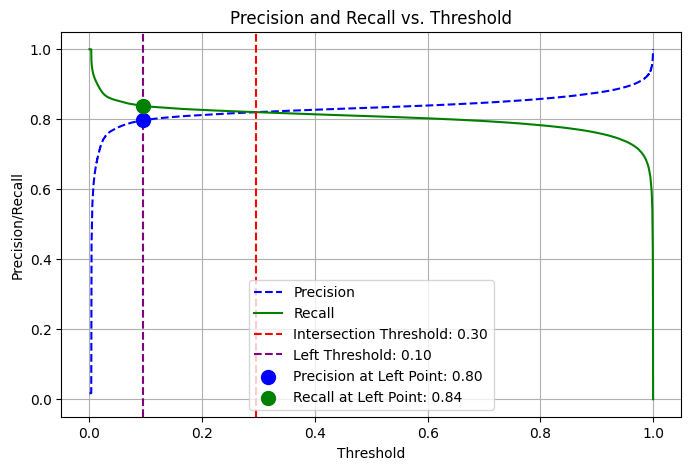

In [18]:
# Directory paths
val_image_dir = 'brain_tumor_segmentation/val/images'
val_mask_dir = 'brain_tumor_segmentation/val/masks'

# Load and preprocess validation images
val_images = []
val_filenames = os.listdir(val_image_dir)
for filename in val_filenames:
    img_path = os.path.join(val_image_dir, filename)
    img = load_img(img_path, target_size=(512, 512), color_mode='grayscale')
    img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
    val_images.append(img_array)

# Convert list to a numpy array
X_val = np.array(val_images)

# Make predictions with the model
predictions = model.predict(X_val)

# Load true masks to create y_val for threshold evaluation
y_val = []
for filename in val_filenames:  # Assuming masks have the same filenames as images
    mask_path = os.path.join(val_mask_dir, filename.replace('.jpg', '_mask.jpg'))  # Adjust the extension if different
    mask = load_img(mask_path, target_size=(512, 512), color_mode='grayscale')
    mask_array = img_to_array(mask) / 255.0  # Normalize to [0, 1]
    y_val.append(mask_array)

y_val = np.array(y_val).flatten()  # Flatten y_val to match the predictions shape

# Evaluate different thresholds using precision and recall
precisions, recalls, thresholds = precision_recall_curve(y_val.flatten(), predictions.flatten())

# Calculate the intersection point
intersection_index = np.argmin(np.abs(precisions - recalls))
intersection_threshold = thresholds[intersection_index]

# Calculate the point 0.2 units to the left
left_threshold_index = np.argmin(np.abs(thresholds - (intersection_threshold - 0.2)))
left_threshold = thresholds[left_threshold_index]
left_precision = precisions[left_threshold_index]
left_recall = recalls[left_threshold_index]

# Plot the precision-recall curve
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.axvline(x=intersection_threshold, color='r', linestyle='--', label=f'Intersection Threshold: {intersection_threshold:.2f}')
plt.axvline(x=left_threshold, color='purple', linestyle='--', label=f'Left Threshold: {left_threshold:.2f}')
plt.scatter([left_threshold], [left_precision], color='blue', s=100, zorder=5, label=f'Precision at Left Point: {left_precision:.2f}')
plt.scatter([left_threshold], [left_recall], color='green', s=100, zorder=5, label=f'Recall at Left Point: {left_recall:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.title('Precision and Recall vs. Threshold')
plt.legend(loc='best')
plt.grid(True)
plt.show()

#Plot Training History with Precision, Recall, and Dice Coefficient

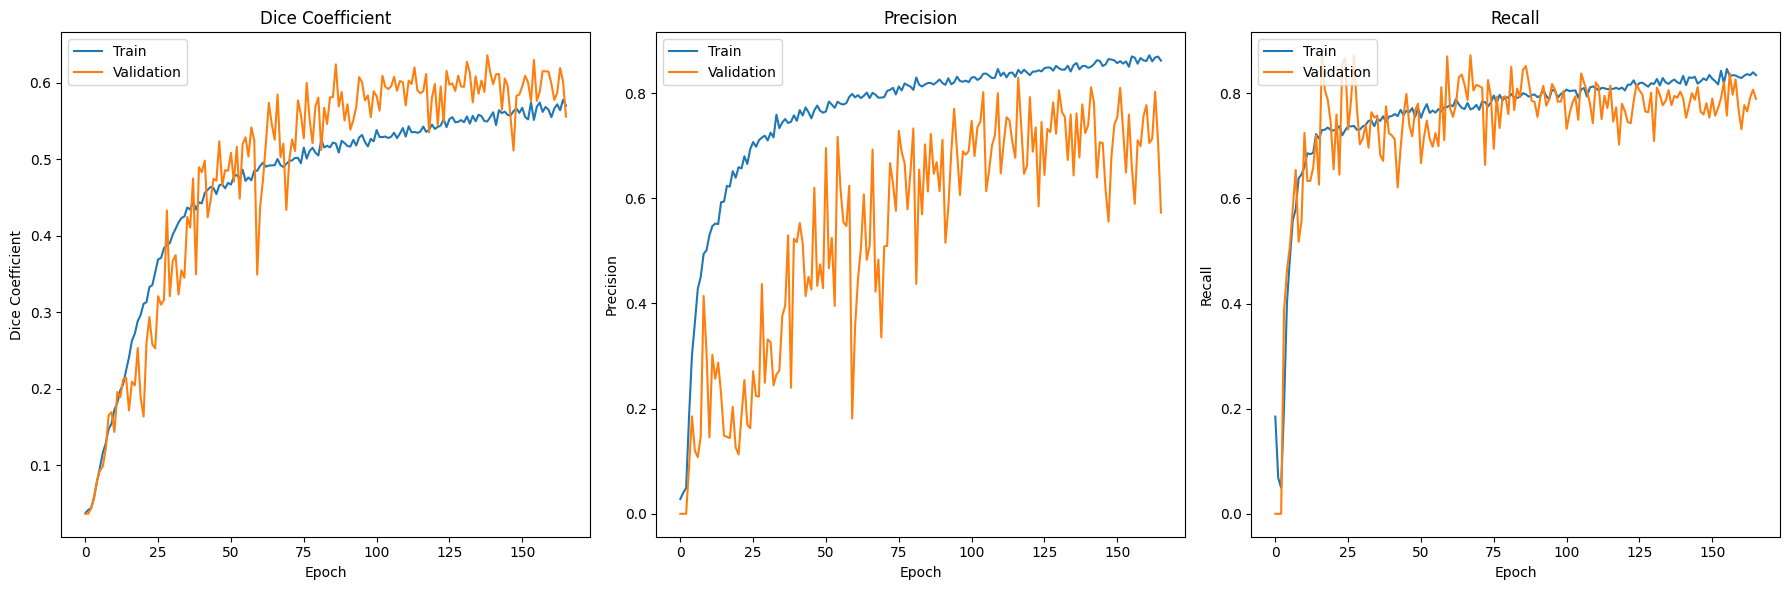

In [16]:
# Load the training history
history_file_path = '/content/drive/My Drive/MENG/ANN/history/training_history.pkl'
with open(history_file_path, 'rb') as file:
    saved_history = pickle.load(file)

# Create a dummy history object to use with the plotting function
class DummyHistory:
    def __init__(self, history):
        self.history = history

history = DummyHistory(saved_history)

def plot_training_history(history):
    # Check if necessary keys exist in history
    required_keys = ['dice_coef', 'val_dice_coef', 'precision', 'val_precision', 'recall', 'val_recall']
    if all(key in history.history for key in required_keys):
        plt.figure(figsize=(18, 6))

        # Plot Dice Coefficient
        plt.subplot(1, 3, 1)
        plt.plot(history.history['dice_coef'])
        plt.plot(history.history['val_dice_coef'])
        plt.title('Dice Coefficient')
        plt.ylabel('Dice Coefficient')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

        # Plot Precision
        plt.subplot(1, 3, 2)
        plt.plot(history.history['precision'])
        plt.plot(history.history['val_precision'])
        plt.title('Precision')
        plt.ylabel('Precision')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

        # Plot Recall
        plt.subplot(1, 3, 3)
        plt.plot(history.history['recall'])
        plt.plot(history.history['val_recall'])
        plt.title('Recall')
        plt.ylabel('Recall')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

        plt.tight_layout()
        plt.show()
    else:
        print("Required keys are missing in the history object")

# Plot the training history
plot_training_history(history)

#Evaluate the model(model.evaluate)

In [40]:
# Evaluate the model using model.evaluate
test_steps = len(os.listdir(test_image_dir)) // BATCH_SIZE
results = model.evaluate(test_generator, steps=test_steps)

# Assuming the following order of metrics from the model.evaluate output
metrics = ['Loss', 'Accuracy', 'AUC (model.evaluate)', 'Dice_coef', 'IoU_metric', 'MeanIoU', 'Precision', 'Recall']

# Create a DataFrame to display the results
results_df = pd.DataFrame(data={'Metric': metrics, 'Value': results})

# Display the DataFrame as a table
print(results_df)

57/57 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9951 - auc: 0.9700 - dice_coef: 0.6556 - iou_metric: 0.5362 - loss: 1.0161 - mean_io_u: 0.4920 - precision: 0.8678 - recall: 0.8171
                 Metric     Value
0                  Loss  1.013947
1              Accuracy  0.994957
2  AUC (model.evaluate)  0.491665
3             Dice_coef  0.873668
4            IoU_metric  0.815348
5               MeanIoU  0.969246
6             Precision  0.548125
7                Recall  0.667244


#Custom Metric Calculations

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

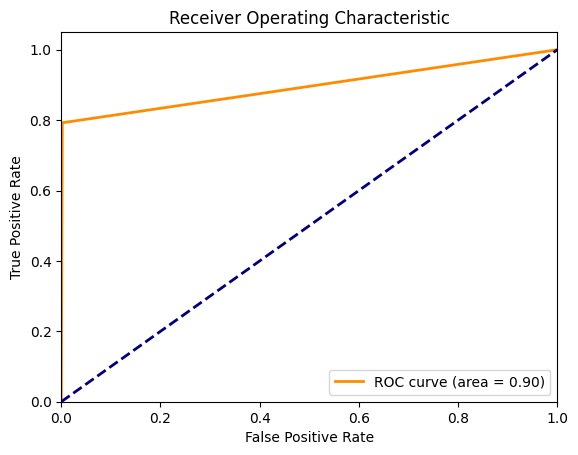

In [20]:
# Define metrics
def iou(y_true, y_pred):
    intersection = np.sum((y_true * y_pred) > 0.5)
    union = np.sum((y_true + y_pred) > 0.5)
    return intersection / union

def dice_coefficient(y_true, y_pred):
    intersection = np.sum((y_true * y_pred) > 0.5)
    return 2.0 * intersection / (np.sum(y_true) + np.sum(y_pred))

def specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0, 0]
    fp = cm[0, 1]
    return tn / (tn + fp)

def flatten_and_binarize(y_true, y_pred):
    y_true_flat = (y_true > 0.5).astype(int).flatten()
    y_pred_flat = (y_pred > 0.5).astype(int).flatten()
    return y_true_flat, y_pred_flat

def calculate_metrics(y_true, y_pred):
    y_true_flat, y_pred_flat = flatten_and_binarize(y_true, y_pred)

    cm = confusion_matrix(y_true_flat, y_pred_flat)
    precision = precision_score(y_true_flat, y_pred_flat)
    recall = recall_score(y_true_flat, y_pred_flat)
    f1 = f1_score(y_true_flat, y_pred_flat)
    spec = specificity(y_true_flat, y_pred_flat)
    fpr, tpr, _ = roc_curve(y_true_flat, y_pred_flat)
    roc_auc = auc(fpr, tpr)

    iou_score = iou(y_true_flat, y_pred_flat)
    dice_score = dice_coefficient(y_true_flat, y_pred_flat)

    return cm, precision, recall, f1, spec, fpr, tpr, roc_auc, iou_score, dice_score

# Example of evaluating the model using custom metrics
def evaluate_model(model, test_generator, test_steps):
    # Collect predictions and true masks
    all_true = []
    all_preds = []

    for _ in range(test_steps):
        test_images, test_masks = next(test_generator)
        preds = model.predict(test_images)

        all_true.extend(test_masks)
        all_preds.extend(preds)

    # Convert lists to numpy arrays
    all_true = np.array(all_true)
    all_preds = np.array(all_preds)

    # Calculate custom metrics
    metrics = calculate_metrics(all_true, all_preds)

    # Print metrics
    # Create and display the labeled confusion matrix DataFrame
    cm_df = pd.DataFrame(metrics[0],
                         index=['Actual Positive', 'Actual Negative'],
                         columns=['Predicted Positive', 'Predicted Negative'])

    # Create a DataFrame for the rest of the metrics with two columns: 'Metric' and 'Value'.
    metrics_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1 Score', 'Specificity', 'AUC', 'IoU', 'Dice Coefficient'],
    'Value': [metrics[1], metrics[2], metrics[3], metrics[4], metrics[7], metrics[8], metrics[9]]})

    print("Confusion Matrix:")
    print(cm_df)

    print("\nOther Metrics:")
    print(metrics_df)

    print('\nROC Curve')
    # Plot ROC Curve
    plt.figure()
    plt.plot(metrics[5], metrics[6], color='darkorange', lw=2, label=f'ROC curve (area = {metrics[7]:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

evaluate_model(model, test_generator, test_steps)

#Plot sample prediction using threshold

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


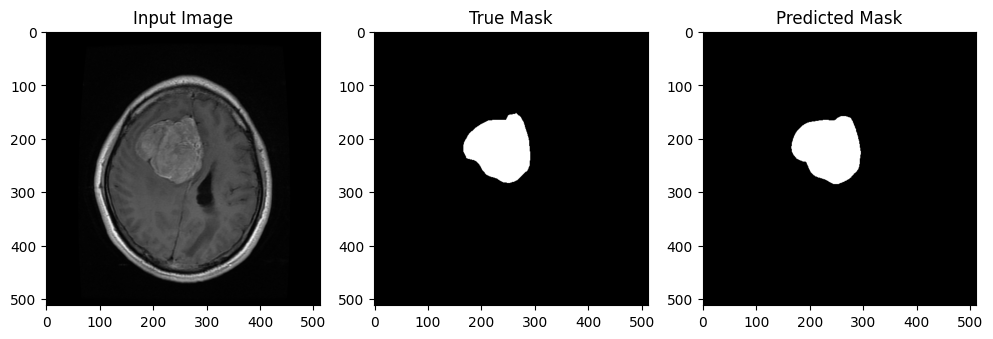

In [38]:
def apply_threshold(prediction, threshold=0.25):
    """
    Apply a threshold to the predicted mask to convert it to a binary mask.
    """
    binary_prediction = (prediction >= threshold).astype(np.uint8)
    return binary_prediction

def plot_sample(image, mask, prediction, threshold=0.3):
    # Apply threshold to the prediction
    binary_prediction = apply_threshold(prediction, threshold)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(image[:, :, 0], cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(mask[:, :, 0], cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(binary_prediction[:, :, 0], cmap='gray')

    plt.show()

# Obtain a batch of test images and masks from the test generator
test_images, test_masks = next(test_generator)

# Make predictions on the test images
preds = model.predict(test_images)

# Plot a sample from the test set with a specified threshold
threshold = 0.10
plot_sample(test_images[0], test_masks[0], preds[0], threshold=threshold)